In [3]:
import pandas as pd 
import numpy as np
from scipy.optimize import minimize 
#SLSQP, COBYLA allow constraints, therefore we use it mostly 
from functools import partial 
import matplotlib.pyplot as plt


# ------------------------------------ parameter ------------------------------------ 
# (0, 1) means long-only, since weighting of each stock are bounded to be in [0, 1].
# If you allow short selling, set lb=-1000, ub=1000. Although the Efficient frontier would be smooth
# Because in real life you cannot take such high leverage
lb = 0.0 #0.0 lower bound of the wrighting of each stock
ub = 1.0 #1.0  upper bound of the wrighting of each stock

# use weekly or monthly return for mean-variance analysis
useWeekly = False
alpha = 0.1
riskMeasure = 'vol' #vol, VaR, CVaR


## objective function = variance of portfolio, goal is to find the minimum variance portfolio for each specified target mean
## The optimize function should be put in the first parameter
## !! First param always the variable target parameter
## !! params after it always in same order as input to function
def MV(w, cov_mat):
    return np.dot(w, np.dot(cov_mat,w.T))

In [5]:
#read_data - existing portfolio
data = pd.read_excel('biggestETFData.xlsx',engine = 'openpyxl',index_col = 0)
data.index = pd.to_datetime(data.index)
start = data.index[0]
end = data.index[-1]
monthend = pd.date_range(start,end,freq='BM')

if useWeekly:
    data_m = data[data.index.dayofweek ==4]
else:
    data_m = data[data.index.isin(monthend)]

data_m_ret = (data_m / data_m.shift()-1).dropna(how = 'all')
data_m_ret

,SPY US Equity,VTI US Equity,QQQ US Equity,VTV US Equity,IWF US Equity,VUG US Equity,IWM US Equity,IWD US Equity,VO US Equity,VYM US Equity,...,XLY US Equity,XLP US Equity,XLU US Equity,IWP US Equity,XLI US Equity,IWS US Equity,VOE US Equity,IWV US Equity,IWO US Equity,SCHG US Equity
2010-02-26,0.031195,0.034400,0.046039,0.026159,0.034867,0.038720,0.044751,0.030662,0.052759,0.024437,...,0.055690,0.031679,-0.013207,0.048932,0.053324,0.048149,0.047509,0.033731,0.042331,0.039614
2010-03-31,0.056529,0.059755,0.075961,0.055891,0.054394,0.056409,0.079658,0.062457,0.069997,0.049033,...,0.076016,0.033296,0.017845,0.062637,0.083218,0.070898,0.069793,0.059104,0.077693,0.056789
2010-04-30,0.015491,0.021816,0.022373,0.017832,0.010780,0.015187,0.056746,0.026036,0.036241,0.016928,...,0.060292,-0.010741,0.026298,0.033594,0.042574,0.044136,0.039308,0.022090,0.042736,0.013508
2010-05-31,-0.079482,-0.078831,-0.073877,-0.077672,-0.076747,-0.082632,-0.075366,-0.082030,-0.072910,-0.078758,...,-0.070362,-0.046326,-0.055191,-0.069791,-0.091188,-0.077179,-0.074455,-0.077350,-0.065209,-0.082746
2010-06-30,-0.056223,-0.062935,-0.063377,-0.057830,-0.054662,-0.059733,-0.077509,-0.057545,-0.062020,-0.050162,...,-0.100093,-0.032258,-0.017385,-0.063237,-0.073311,-0.062275,-0.062687,-0.058715,-0.067516,-0.058631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-30,0.014772,0.013151,0.007148,0.028566,-0.001876,0.000602,0.016797,0.029539,0.017731,0.029828,...,0.009366,0.011528,0.034516,-0.012574,0.024683,0.035558,0.040037,0.013827,-0.010118,0.000476
2019-10-31,0.022105,0.021060,0.043801,0.018993,0.028253,0.025920,0.027157,0.014112,0.011098,0.010481,...,0.001243,-0.004233,-0.007569,0.018606,0.011336,0.005574,0.003805,0.021465,0.029990,0.031901
2019-11-29,0.036198,0.037878,0.040694,0.034377,0.044413,0.039920,0.040656,0.030830,0.032220,0.023422,...,0.013240,0.013734,-0.018677,0.049104,0.044962,0.026164,0.031649,0.037915,0.057730,0.045334
2019-12-31,0.024021,0.022497,0.036616,0.018700,0.026191,0.026888,0.024108,0.017900,0.018637,0.021251,...,0.024255,0.015806,0.024901,0.010129,-0.006948,0.023876,0.018544,0.023123,0.020241,0.025270


In [99]:
# n = number of stocks
n = len(data_m_ret.columns)

# instantiate volRange for storing variance
mu_step = 0.0002
muRange = np.arange(0.0055,0.013,mu_step)
volRange = np.zeros(len(muRange))

# mean return and covariance matrix
R = data_m_ret.mean()
omega = data_m_ret.cov()


In [100]:
# weighting of minimum variance portfolio with that mean return
wgt = {}

for i in range(len(muRange)):
    mu = muRange[i]
    wgt[mu] = []
    
    # initial weight = equal weight
    x_0 = np.ones(n)/n 
    
    # bounds for weighting of each stock in optimization
    bndsa = ((lb,ub),)
    for j in range(1,n):
        bndsa = bndsa +((lb,ub),)
    
    # constraint 1 --> type=equality --> sum(weightings) = 1
    # constraint 2 --> type=equality --> np.dot(w^T, R) = mu 
    consTR = ({'type':'eq','fun':lambda x:1-np.sum(x)},{'type':'eq','fun':lambda x: mu - np.dot(x,R)}) 
    
    # args: a tuple of the fixed parameters needed to completely specify the function
    # func: The objective function to be minimized.;  fun(x, *args) -> float
    # x_0: initial guess. Array of real elements of size (n,), where ‘n’ is the number of independent variables.
    # bounds: Bounds on variables. Sequence of (min, max) pairs for each element in x. None is used to specify no bound.
    w = minimize(MV, x_0, method = 'SLSQP', constraints = consTR, bounds = bndsa, args = (omega))
    
    # w.x is solution array
    # record SD of that optimal portfolio. i.e. minimal variance of portfolio with that average return
    volRange[i] = np.dot(w.x,np.dot(omega,w.x.T))**0.5
    
    # record the weightings of that optimal portfolio
    wgt[mu].extend(np.squeeze(w.x))

# efficient frontier 
EF_df = pd.DataFrame.from_dict(wgt,orient = 'columns').T

In [101]:
# save result
EF_df.to_excel('Efficient_Frontier.xlsx')
EF_df.columns = data.columns
EF_df

,SPY US Equity,VTI US Equity,QQQ US Equity,VTV US Equity,IWF US Equity,VUG US Equity,IWM US Equity,IWD US Equity,VO US Equity,VYM US Equity,...,XLY US Equity,XLP US Equity,XLU US Equity,IWP US Equity,XLI US Equity,IWS US Equity,VOE US Equity,IWV US Equity,IWO US Equity,SCHG US Equity
0.0055,1.448321e-20,2.766870e-18,1.735025e-18,0.000000e+00,0.000000e+00,1.842763e-18,0.000000e+00,0.000000e+00,1.199844e-18,0.000000e+00,...,2.343261e-19,1.466287e-01,0.291327,6.633217e-19,8.197214e-19,3.889630e-19,0.000000e+00,0.000000e+00,6.023455e-19,1.060881e-18
0.0057,1.295448e-19,7.596547e-19,0.000000e+00,0.000000e+00,3.235326e-18,1.761104e-18,3.104451e-18,0.000000e+00,1.627257e-18,3.298708e-02,...,0.000000e+00,1.454923e-01,0.258635,1.050940e-18,0.000000e+00,3.538230e-18,0.000000e+00,0.000000e+00,6.588865e-19,2.706904e-19
0.0059,2.749564e-18,0.000000e+00,0.000000e+00,0.000000e+00,4.425886e-19,2.296976e-18,0.000000e+00,1.040834e-17,0.000000e+00,3.684818e-02,...,5.749501e-19,1.556631e-01,0.276521,1.135041e-18,2.375462e-19,0.000000e+00,0.000000e+00,1.832877e-19,4.287464e-19,7.311178e-20
0.0061,0.000000e+00,0.000000e+00,6.341812e-19,0.000000e+00,0.000000e+00,0.000000e+00,5.672036e-19,0.000000e+00,0.000000e+00,1.387779e-17,...,0.000000e+00,1.825286e-01,0.366736,0.000000e+00,1.607256e-19,2.923233e-19,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
0.0063,0.000000e+00,0.000000e+00,2.127424e-18,0.000000e+00,5.019750e-19,8.945852e-19,3.031447e-18,0.000000e+00,0.000000e+00,4.500797e-02,...,0.000000e+00,1.757599e-01,0.311869,0.000000e+00,3.256321e-19,0.000000e+00,0.000000e+00,0.000000e+00,4.161076e-20,4.697397e-19
0.0065,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.372177e-18,3.842956e-19,3.710021e-18,0.000000e+00,1.491821e-18,4.923369e-02,...,0.000000e+00,1.858350e-01,0.329619,0.000000e+00,7.233427e-19,4.242195e-18,3.046943e-20,0.000000e+00,0.000000e+00,0.000000e+00
0.0067,3.485501e-18,0.000000e+00,0.000000e+00,1.801691e-02,0.000000e+00,1.135091e-18,0.000000e+00,2.163109e-02,4.154550e-19,6.472674e-02,...,5.974715e-20,1.792381e-01,0.301859,0.000000e+00,0.000000e+00,1.905272e-18,0.000000e+00,3.095846e-19,2.352504e-19,2.882843e-19
0.0069,0.000000e+00,3.114657e-19,0.000000e+00,5.204170e-18,3.317967e-19,0.000000e+00,8.191686e-19,1.760514e-03,0.000000e+00,5.917166e-02,...,3.229584e-19,2.050065e-01,0.362170,4.465828e-21,0.000000e+00,1.914919e-18,0.000000e+00,0.000000e+00,2.877208e-19,1.620075e-20
0.0071,6.343062e-18,1.825011e-18,8.218364e-19,2.266059e-02,4.040371e-19,3.161504e-19,1.007836e-18,2.220951e-02,7.447924e-19,7.163865e-02,...,1.630897e-18,1.931488e-01,0.326122,6.695420e-19,1.740190e-18,2.776526e-18,0.000000e+00,1.663993e-18,5.679407e-19,7.346100e-19
0.0073,0.000000e+00,4.217856e-19,0.000000e+00,2.486308e-02,0.000000e+00,0.000000e+00,2.130271e-18,2.227204e-02,2.583243e-19,7.507646e-02,...,0.000000e+00,2.002473e-01,0.338676,0.000000e+00,1.053947e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


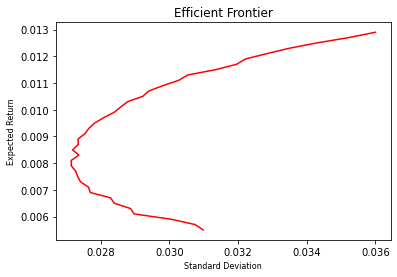

In [102]:
# plot the efficient frontier
# If weightings are bounded to be long-only [0,1], EF will not be smooth
plot1=plt.figure(1)
plt.plot(volRange,muRange,color="red")
plt.xlabel("Standard Deviation",fontsize=8)
plt.ylabel("Expected Return",fontsize=8)
plt.title("Efficient Frontier",fontsize=12)

# save fig
plt.savefig('Efficient_Frontier(NoRiskFree).png')

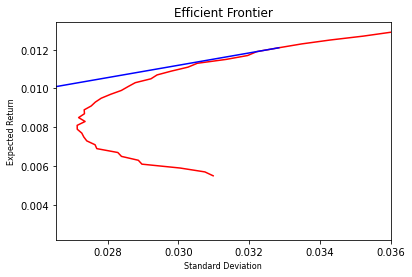

In [114]:
# risk-free rate, same period as return
rf=0.02/12
rf_weighting = np.arange(0,1,0.1)

mean_var_df = pd.DataFrame({'mean': muRange, 'sd': volRange})
mean_var_df['slope'] = (mean_var_df['mean'] - rf) / mean_var_df['sd']
tangent_portfolio = mean_var_df.loc[mean_var_df['slope'].argmax()]


plot1=plt.figure(1)
plt.plot(volRange,muRange,color="red")
plt.plot([(1-x) * tangent_portfolio['sd'] for x in rf_weighting],
         [(1-x) * tangent_portfolio['mean'] + rf * x for x in rf_weighting],
         color='blue')
plt.xlim([min(mean_var_df['sd'])-mu_step*3, max(mean_var_df['sd'])])
plt.xlabel("Standard Deviation",fontsize=8)
plt.ylabel("Expected Return",fontsize=8)
plt.title("Efficient Frontier",fontsize=12)

# save fig
plt.savefig('Efficient_Frontier(RiskFree).png')